# 백테스팅 시뮬레이션

## bt 패키지

### 데이터의 수집

In [1]:
# bt 패키지의 get() 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해준다.
import bt

data = bt.get('SPY, TLT', start='2003-01-01', end='2021-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,spy,tlt
Date,,
2003-01-02,61.366566,43.399532
2003-01-03,61.555222,43.500122
2003-01-06,62.640110,43.384441
2003-01-07,62.485153,43.540394
2003-01-08,61.582203,43.756668


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import keyring

user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.106'
engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:3306/stock')
price = pd.read_sql('SELECT * FROM sample_etf;', con=engine)
engine.dispose()

price.tail()

,Date,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
7760,2023-11-22,455.019989,50.160000,62.490002,39.520000,90.870003,92.750000,82.250000,24.920000,184.559998,24.180000
7761,2023-11-24,455.299988,50.669998,62.610001,39.540001,89.800003,92.269997,82.550003,25.049999,185.520004,24.020000
7762,2023-11-27,454.480011,50.500000,62.560001,39.380001,91.300003,92.970001,82.849998,25.049999,186.770004,23.860001
7763,2023-11-28,454.929993,50.490002,62.549999,39.709999,91.480003,93.379997,83.339996,25.120001,189.259995,24.150000
7764,2023-11-29,454.609985,50.689999,62.490002,39.480000,92.629997,93.870003,83.949997,25.170000,189.539993,24.320000


### 전략의 정의

In [3]:
import bt

# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW", [        # 전략의 이름
    bt.algos.SelectAll(),                   # 모든 데이터를 사용함을 정의
    bt.algos.WeighEqually(),                # 동일 비중으로 투자할 것을 정의
    bt.algos.RunMonthly(),                  # 매 월말 리밸런싱
    bt.algos.Rebalance()                    # 계산된 비중에 따라 리밸런싱
])

### 전략의 백테스트

In [4]:
data = price.dropna()       # 시작점이 모두 다르므로, dropna() 함수를 통해 NA를 모두 제거
data.set_index('Date', inplace=True)

# 백테스트 생성
backtest = bt.Backtest(strategy, data)

# 백테스트 실행
result = bt.run(backtest)

### 결과에 대한 평가

In [5]:
# prices : 누적 수익률, 시작 시점을 100으로 환산하여 계산
result.prices

,Asset_EW
2006-12-18,100.000000
2006-12-19,100.000000
2006-12-20,100.208601
2006-12-21,100.077613
2006-12-22,100.038759
...,...
2023-11-22,205.809861
2023-11-24,205.898856
2023-11-27,206.268547
2023-11-28,207.269442


In [6]:
# prices에 to_returns()를 입력하면 수익률이 계산된다.
result.prices.to_returns()

,Asset_EW
2006-12-18,NaN
2006-12-19,0.000000
2006-12-20,0.002086
2006-12-21,-0.001307
2006-12-22,-0.000388
...,...
2023-11-22,0.000360
2023-11-24,0.000432
2023-11-27,0.001795
2023-11-28,0.004852


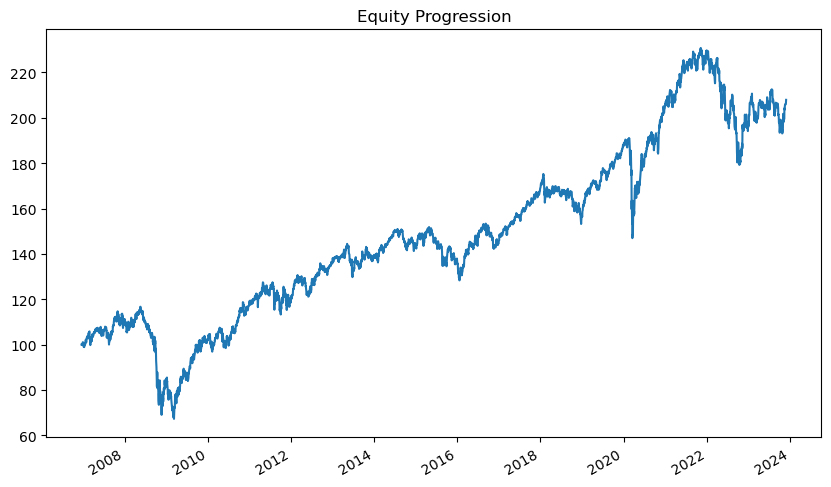

In [7]:
import matplotlib.pyplot as plt

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [8]:
# get_security_weights() 메서드를 통해 각 종목별 추자 비중 확인 가능
result.get_security_weights().head()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
2006-12-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-19,0.099999,0.099998,0.099996,0.099994,0.099981,0.100000,0.099994,0.099978,0.099992,0.099998
2006-12-20,0.099735,0.099210,0.100498,0.100890,0.099762,0.099768,0.100615,0.099967,0.099494,0.099992
2006-12-21,0.099500,0.099391,0.101205,0.100841,0.100394,0.100259,0.099778,0.100213,0.099236,0.099114
2006-12-22,0.098927,0.098789,0.101604,0.101242,0.099664,0.099841,0.099042,0.101191,0.099711,0.099919


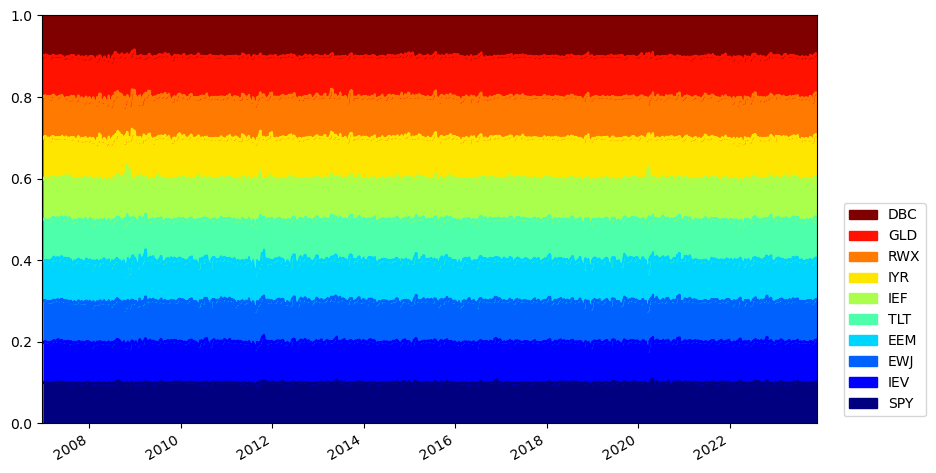

In [9]:
# plot weights
from matplotlib import cm

# area()를 통해 면적 그래프를 나타내며, y축의 범위는 0에서 1, 범례(legend) 제외, 색 구분은 cm.jet 활용
ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                        ylim=[0, 1],
                                        legend=False,
                                        colormap=cm.jet)
# get_legend_handles_labels() 함수를 통해 범례를 받아온다.
handles, labels = ax.get_legend_handles_labels()
# 좌우 마진 0
plt.margins(0, 0)
# legend() 함수를 통해 범례를 나타내며, 그래프와 색 순서를 맞추기 위해 reversed()를 통해 순서를 바꾼다. 
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()


In [10]:
# 성과지표 확인
result.display()

Stat                 Asset_EW
-------------------  ----------
Start                2006-12-18
End                  2023-11-29
Risk-free rate       0.00%

Total Return         107.93%
Daily Sharpe         0.39
Daily Sortino        0.60
CAGR                 4.41%
Max Drawdown         -42.35%
Calmar Ratio         0.10

MTD                  7.12%
3m                   0.67%
6m                   2.83%
YTD                  6.19%
1Y                   5.78%
3Y (ann.)            1.63%
5Y (ann.)            5.27%
10Y (ann.)           4.06%
Since Incep. (ann.)  4.41%

Daily Sharpe         0.39
Daily Sortino        0.60
Daily Mean (ann.)    5.25%
Daily Vol (ann.)     13.61%
Daily Skew           -0.21
Daily Kurt           10.24
Best Day             7.81%
Worst Day            -6.77%

Monthly Sharpe       0.41
Monthly Sortino      0.66
Monthly Mean (ann.)  5.02%
Monthly Vol (ann.)   12.16%
Monthly Skew         -0.82
Monthly Kurt         3.62
Best Month           8.67%
Worst Month          -17.98%

Year

## 정적 자산배분 : 올웨더 포트폴리오

In [14]:
# all weather portfolio backtesting
import bt
import matplotlib.pyplot as plt

data = price[['Date', 'SPY', 'TLT', 'IEF', 'GLD', 'DBC']].dropna()

data.set_index('Date', inplace=True)

aw = bt.Strategy(
    'All Weather', [
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(SPY=0.3, TLT=0.4, IEF=0.15, GLD=0.075, DBC=0.075),
        bt.algos.RunQuarterly(),
        bt.algos.Rebalance()
    ]
)

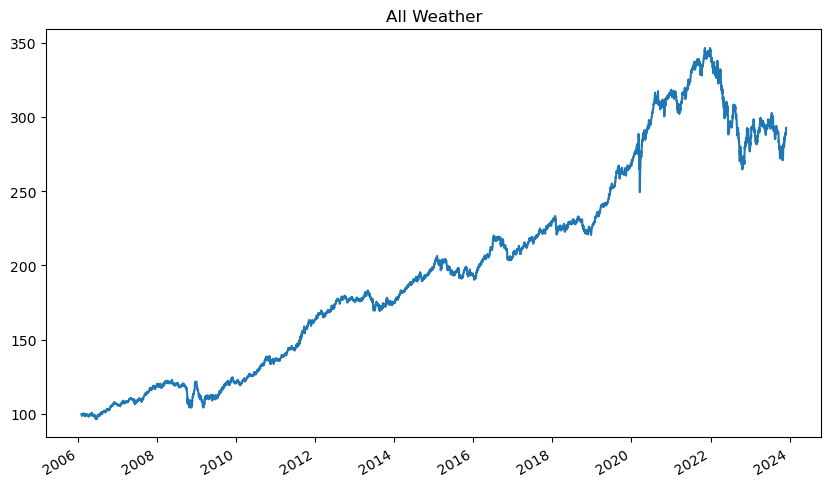

In [16]:
aw_backtest = bt.Backtest(aw, data)
aw_result = bt.run(aw_backtest)

aw_result.plot(figsize=(10, 6), title='All Weather', legend=False)
plt.show()

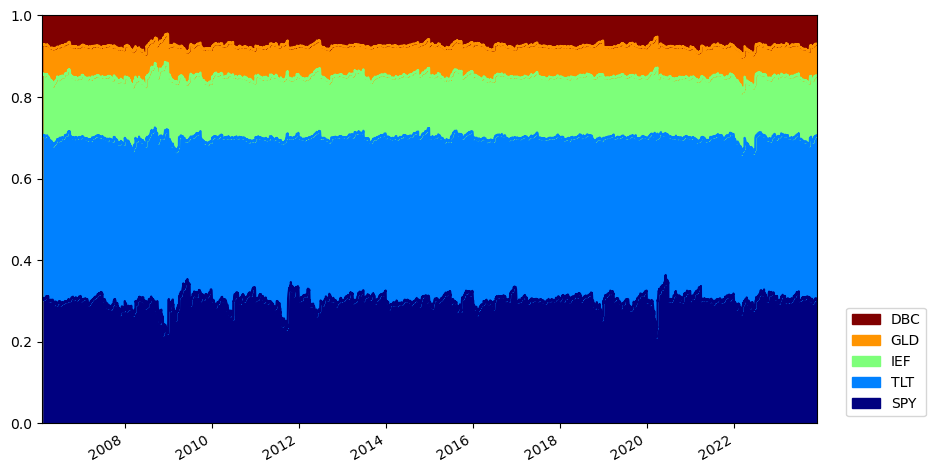

In [27]:
# 자산 비중
from matplotlib import cm

ax = aw_result.get_security_weights().plot.area(
    figsize=(10, 6),
    ylim = [0, 1],
    legend=False,
    colormap=cm.jet
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(
    reversed(handles),
    reversed(labels),
    loc='lower right',
    bbox_to_anchor=(1.15, 0)
)
plt.show()

In [21]:
# 주요 성과 지표
aw_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe'
]]

,All Weather
total_return,1.926781
cagr,0.062144
daily_vol,0.08094
max_drawdown,-0.236036
calmar,0.263282
daily_sharpe,0.786052


## 동적 자산배분

In [46]:
import bt
import matplotlib.pyplot as plt

data = price.dropna().set_index('Date')
data

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2006-12-19,102.879883,31.917747,43.325676,26.488396,54.367031,55.679230,43.934036,26.275335,61.799999,22.972263
2006-12-20,102.821991,31.732323,43.634224,26.781502,54.360962,55.665813,44.299290,26.327335,61.619999,23.018652
2006-12-21,102.445839,31.748484,43.883564,26.733566,54.633900,55.866661,43.873348,26.357655,61.380001,22.786703
2006-12-22,101.816490,31.544094,44.039406,26.829430,54.215424,55.612259,43.532578,26.604656,61.650002,22.962984
2006-12-26,102.416916,31.568489,44.008236,27.078682,54.379158,55.652435,43.969189,26.691301,61.980000,22.610426
...,...,...,...,...,...,...,...,...,...,...
2023-11-22,455.019989,50.160000,62.490002,39.520000,90.870003,92.750000,82.250000,24.920000,184.559998,24.180000
2023-11-24,455.299988,50.669998,62.610001,39.540001,89.800003,92.269997,82.550003,25.049999,185.520004,24.020000
2023-11-27,454.480011,50.500000,62.560001,39.380001,91.300003,92.970001,82.849998,25.049999,186.770004,23.860001


In [47]:
gdaa = bt.Strategy(
    'GDAA', [
        bt.algos.SelectAll(),
        # 모멘텀 상위 종목 5개 선택, 모멘텀 관측 기간 과거 1년
        bt.algos.SelectMomentum(n=5, lookback=pd.DateOffset(years=1)),
        # 위험균형 포트폴리오 구성, 분산-공분산 계산을 위한 수익률은 과거 1년 데이터 이요
        bt.algos.WeighERC(lookback=pd.DateOffset(years=1)),
        bt.algos.RunMonthly,
        bt.algos.Rebalance()
    ]
)

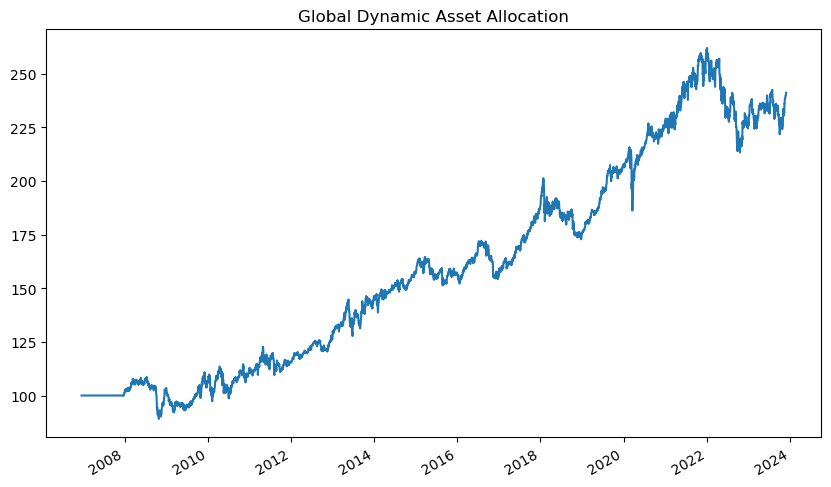

In [48]:
gdaa_backtest = bt.Backtest(gdaa, data)
gdaa_result = bt.run(gdaa_backtest)

gdaa_result.plot(figsize=(10, 6),
                 title='Global Dynamic Asset Allocation',
                 legend=False)
plt.show()

### 거래 비용 고려하기

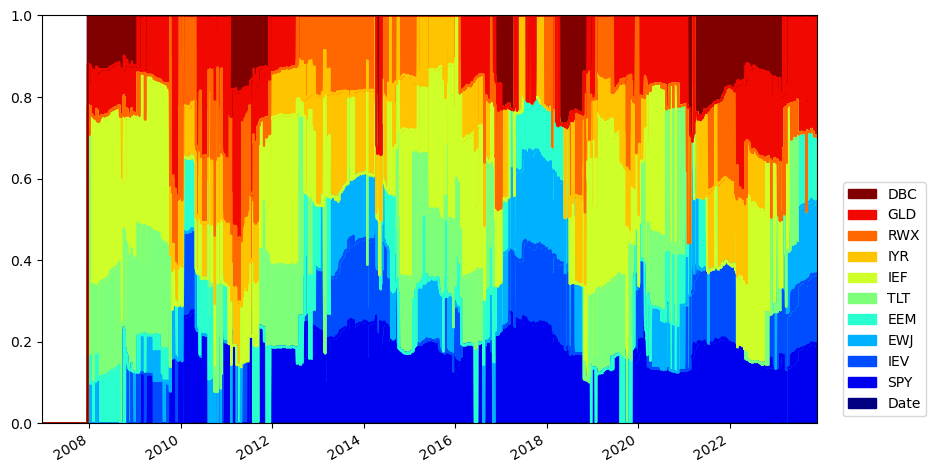

In [49]:
# 투자 비중
from matplotlib import cm
wt = gdaa_result.get_security_weights().reindex(columns=price.columns)
ax = wt.plot.area(figsize=(10, 6), ylim=[0, 1], legend=False, colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

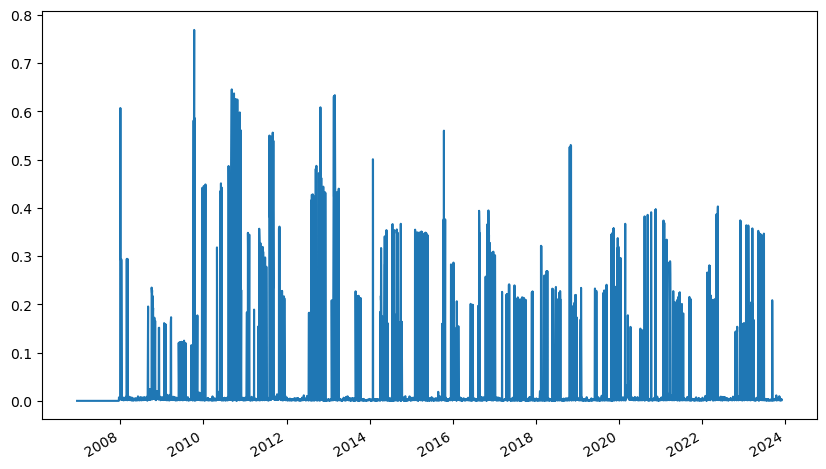

In [50]:
gdaa_backtest.turnover.plot(figsize=(10, 6), legend=False)
plt.show()

In [51]:
# 턴오버 고려 백테스팅
gdaa_backtest_net = bt.Backtest(
    gdaa,
    data,
    name='GDAA_net',
    # q는 quantity(주수), p는 price(주가)를 의미
    commissions=lambda q, p: abs(q) * p * 0.002,
    # 초기 자본 넣지 않으면 에러 발생
    initial_capital=100000.00)

# bt.run() 내에 기존 백테스트와 새롭게 생성된 백테스트를 동시에 입력하면 두 개의 백테스트가 한번에 실행
gdaa_result = bt.run(gdaa_backtest, gdaa_backtest_net)


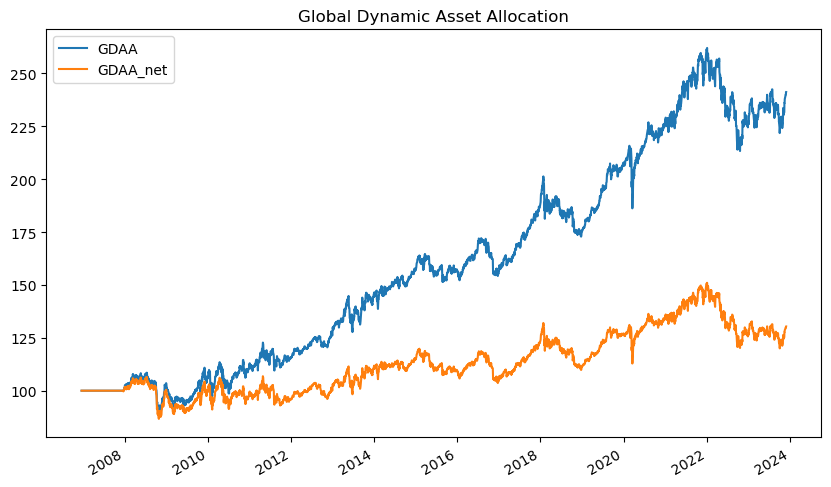

In [43]:
gdaa_result.prices.plot(figsize=(10, 6),
                        title='Global Dynamic Asset Allocation')
plt.show()

## 추세추종 전략 백테스트

### 마켓 타이밍 전략

In [60]:
# SMA
import talib

data = price[['Date', 'SPY']].dropna()
data.set_index('Date', inplace=True)
# 200일 이동평균
sma = data.apply(lambda x: talib.SMA(x, 200))

In [62]:
import bt 
bt_sma = bt.Strategy(
    'Timing', [
        # 입력값이 True 일 때만 투자하도록 정의
        bt.algos.SelectWhere(data > sma),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ]
)

bt_sma_backtest = bt.Backtest(bt_sma, data)

In [63]:
# 단순 매수 후 보유의 경우 정의

def buy_and_hold(data, name):
    # 벤치마크 전략 생성
    bt_strategy = bt.Strategy(
        name, [
            bt.algos.SelectAll(),
            bt.algos.WeighEqually(),
            # 리밸런싱 없이 처음 상태 유지
            bt.algos.RunOnce(),
            bt.algos.Rebalance()
        ]
    )
    
    return bt.Backtest(bt_strategy, data)

# 벤치마크 전략 백테스트
stock = buy_and_hold(data[['SPY']], name='stock')

# 두 개 백테스트 동시 실행
bt_sma_result = bt.run(bt_sma_backtest, stock)

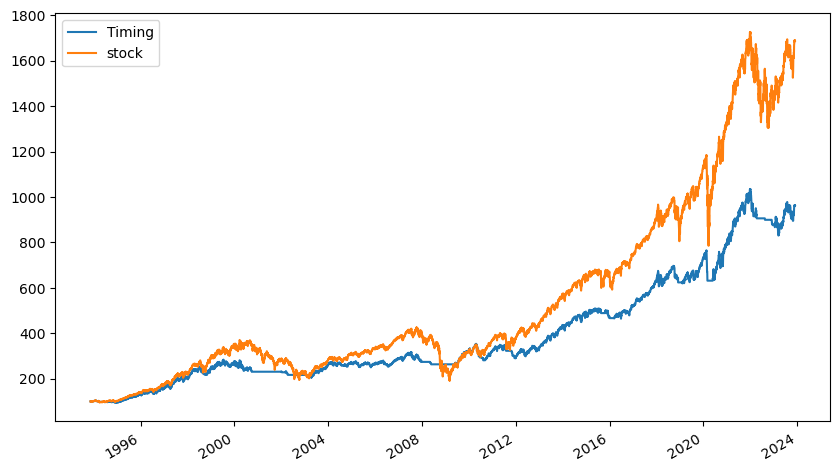

In [64]:
import matplotlib.pyplot as plt

bt_sma_result.prices.iloc[201:, ].rebase().plot(figsize=(10, 6))
plt.show()

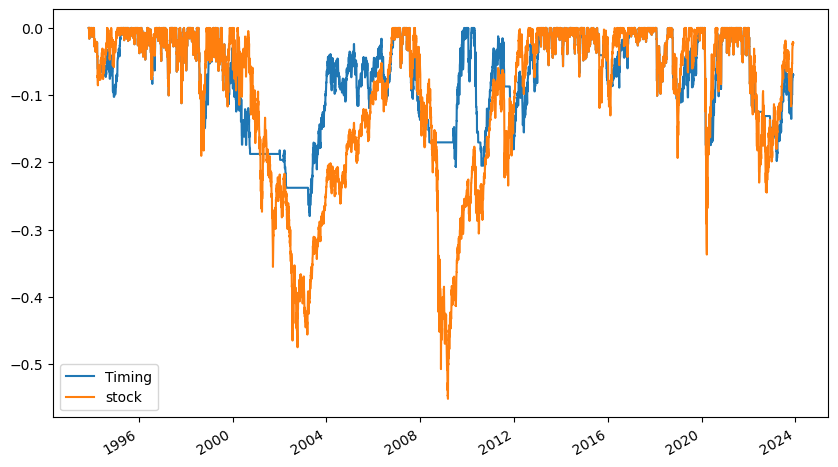

In [66]:
bt_sma_result.prices.iloc[201:, ].rebase().to_drawdown_series().plot(
    figsize=(10, 6)
)
plt.show()

In [67]:
bt_sma_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe', 'daily_sortino'
]]

,Timing,stock
total_return,8.673895,17.226703
cagr,0.076379,0.098721
daily_vol,0.11998,0.187875
max_drawdown,-0.279954,-0.551892
calmar,0.272826,0.178877
daily_sharpe,0.674096,0.595549
daily_sortino,1.021446,0.944633


### 파라미터 최적화

In [73]:
import talib
import bt 

data = price[['Date', 'SPY']].dropna()
data.set_index('Date', inplace=True)

def timing(price, n):
    sma = price.apply(lambda x: talib.SMA(x, n))
    strategy = bt.Strategy(
        n, [
            bt.algos.SelectWhere(price > sma),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance()
        ]
    )
    
    backtest = bt.Backtest(strategy, price)
    
    return (backtest)

n_20 = timing(data, 20)
n_60 = timing(data, 60)
n_100 = timing(data, 100)
n_150 = timing(data, 150)
n_200 = timing(data, 200)
n_250 = timing(data, 250)

result = bt.run(n_20, n_60, n_100, n_150, n_200, n_250)

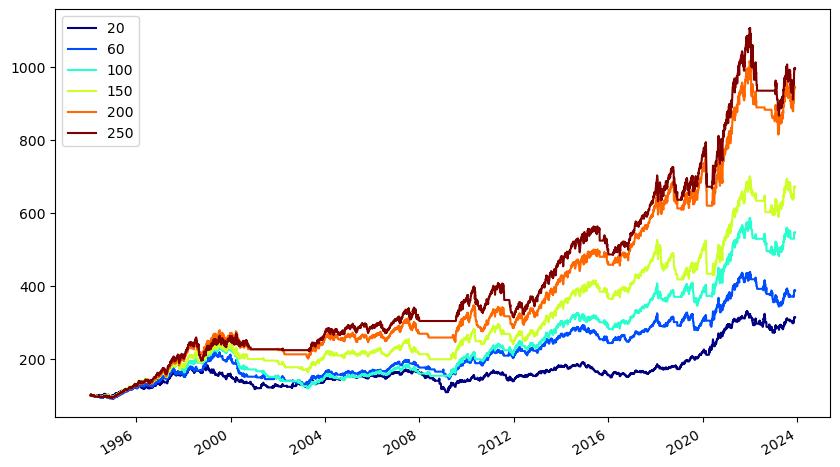

In [74]:
from matplotlib import cm
result.prices[250:].rebase().plot(figsize=(10, 6), colormap=cm.jet)
plt.show()

### 롱숏 전략

In [75]:
import talib

data = price[['Date', 'SPY']]
data.set_index('Date', inplace=True)
SMA_200 = data.apply(lambda x: talib.SMA(x, 200))
SMA_60 = data.apply(lambda x: talib.SMA(x, 60))

In [76]:
signal = SMA_200.copy()
signal[[SMA_60 >= SMA_200]] = 1
signal[[SMA_60 < SMA_200]] = -1
signal[[signal.isnull()]] = 0
signal

,SPY
Date,
1993-01-29,0.0
1993-02-01,0.0
1993-02-02,0.0
1993-02-03,0.0
1993-02-04,0.0
...,...
2023-11-22,1.0
2023-11-24,1.0
2023-11-27,1.0


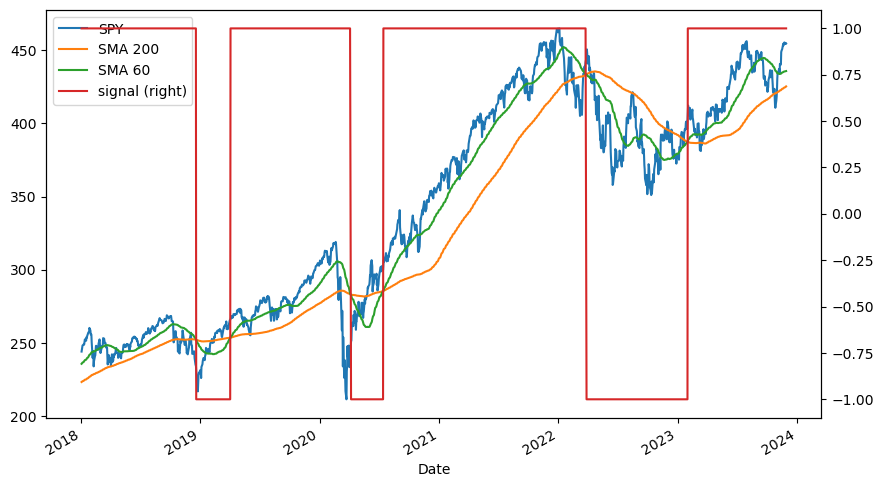

In [77]:
import matplotlib.pyplot as plt

bind = pd.concat([data, SMA_200, SMA_60, signal], axis=1)
bind.columns = ['SPY', 'SMA 200', 'SMA 60', 'signal']
bind.loc['2018':].plot(figsize=(10, 6), secondary_y=['signal'])
plt.show()

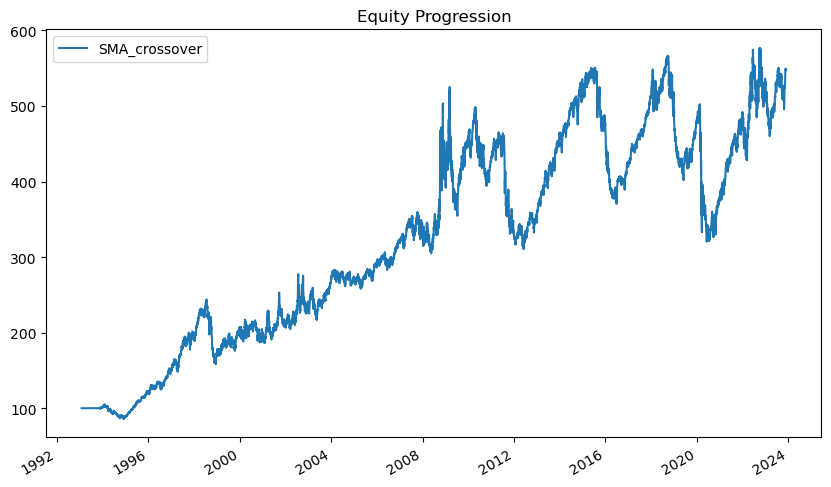

In [78]:
# 1 매수, -1 매도 백테스팅
import bt

strategy = bt.Strategy(
    'SMA_crossover', [
        bt.algos.SelectAll(),
        bt.algos.WeighTarget(signal),
        bt.algos.Rebalance()
    ]
)
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()


In [80]:
# 월별, 연도별 수익률
result.display_monthly_returns()

  Year     Jan    Feb     Mar    Apr    May    Jun    Jul     Aug    Sep     Oct    Nov    Dec     YTD
------  ------  -----  ------  -----  -----  -----  -----  ------  -----  ------  -----  -----  ------
  1993    0      0       0      0      0      0      0       0      0       0     -0.07   1.23    1.16
  1994    3.49  -2.92   -4.19   1.12  -4.8    2.21  -3.16   -3.73  -1.04    2.84  -3.98   0.73  -13.08
  1995    3.36   4.08    2.78   2.96   3.97   2.02   3.22    0.45   4.24   -0.29   4.45   1.57   38.05
  1996    3.56   0.32    1.72   1.09   2.27   0.88  -4.49    1.93   5.59    3.23   7.3   -2.38   22.5
  1997    6.18   0.96   -4.41   6.26   6.32   4.11   7.93   -5.18   4.81   -2.45   3.87   1.91   33.47
  1998    1.29   6.93    4.88   1.28  -2.08   4.26  -1.35  -14.12   6.36  -17.03  -5.51   4.58  -13.23
  1999    3.52  -3.21    4.15   3.8   -2.29   5.54  -3.1    -0.52  -2.23    6.41   1.67   5.71   20.39
  2000   -4.98  -1.52    9.69  -3.51  -1.57   1.97  -1.57    6.53  -5.49  

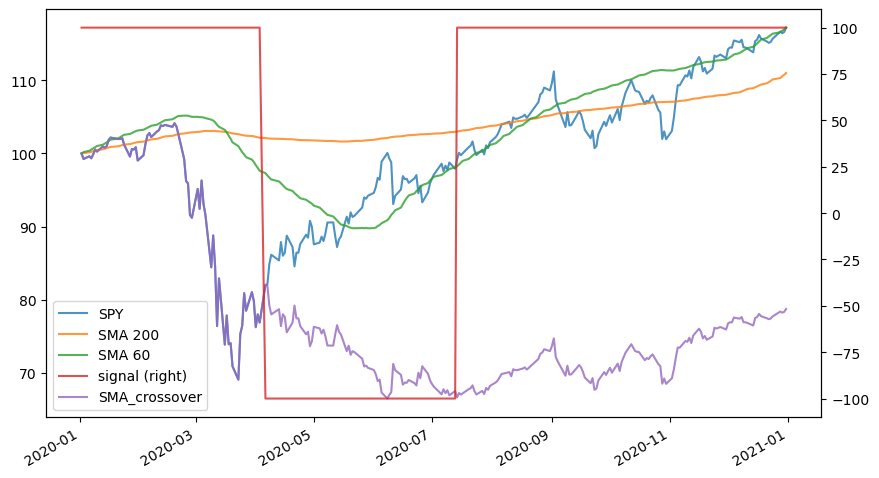

In [81]:
# corona periods
pd.concat([bind, result.prices], 
          axis=1).loc['2020'].rebase().plot(
              figsize=(10, 6),
              secondary_y=['signal'],
              alpha=0.8
          )
plt.show()

## 평균 회귀 전략 백테스트

### RSI를 이용한 전략